# *download and install Miniforge (Linux x86_64)*
# Execute these on a terminal
wget https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh -O ~/miniforge.sh
bash ~/miniforge.sh -b -p $HOME/miniforge
rm ~/miniforge.sh
export PATH="$HOME/miniforge/bin:$PATH"
conda init bash
# restart shell (or `exec bash`)


# Then Execute the following on a terminal to setup bioconda and forge
conda config --add channels bioconda
conda config --add channels conda-forge
conda config --set channel_priority strict

# Finally install mamba (optional) and create a STAR environment
# (optional) install mamba for speed
conda install -n base -c conda-forge mamba -y

# create environment with STAR, samtools, jupyterlab, seqtk (use mamba if installed)
mamba create -n rna_env -c conda-forge -c bioconda star samtools jupyterlab seqtk -y

# activate
conda activate rna_env


In [ ]:
%conda install matplotlib-venn --y
%conda install pandas numpy matplotlib seaborn scikit-learn matplotlib-venn pathlib --y

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/atharva/miniforge/envs/rna_env

  added / updated specs:
    - matplotlib-venn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.1.0               |       hb03c661_4          19 KB  conda-forge
    brotli-bin-1.1.0           |       hb03c661_4          19 KB  conda-forge
    contourpy-1.3.3            |  py313h7037e92_2         290 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_1          13 KB  conda-forge
    fonttools-4.59.2           |  py313h3dea7bd_0         2.8 MB  conda-forge
    kiwisolver-1.4.9           |  py313hc8edb43_1          75 

In [36]:
%conda install -c bioconda salmon bbmap bowtie2 samtools --y

Channels:
 - bioconda
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.3.1
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/atharva/miniforge/envs/rna_env

  added / updated specs:
    - bbmap
    - bowtie2
    - salmon
    - samtools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bbmap-39.33                |       he5f24ec_0        14.2 MB  bioconda
    boost-cpp-1.85.0           |       h3c6214e_4          18 KB  conda-forge
    bowtie2-2.5.4              |       he96a11b_6        14.3 MB  bioconda
    libboost-1.85.0            |       h0ccab89_4         2.7 MB  conda-forge
    libboost-devel-1.85.0      |       h00ab1b0_4          40 KB  conda-forge
    libboost-headers-1.85.0    |    

In [1]:
!STAR --version

2.7.11b


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import subprocess
from pathlib import Path
from matplotlib_venn import venn3
from functools import reduce
import shutil
import sys
import os, subprocess, shlex
# Parallel Processing with Multiprocessing
import gzip
from multiprocessing import Pool, cpu_count
# from Bio import SeqIO
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
import shutil
import subprocess
from pathlib import Path
import multiprocessing as mp
import glob, math
import shlex

In [3]:
p1 = "/mnt/a/Projects/RA_Assignment/Patient1"

# Patient1
if not any(os.scandir(p1)):  # empty dir
    print("Patient1 FASTQs not found → downloading...")
    %cd $p1
    !bash /content/drive/MyDrive/Bio_Informatics_RA_Assignment/ena-file-download-read_run-SAMN03431245-fastq_ftp-20250830-1946.sh

else:
    print("Patient1 FASTQs already exist → skipping download.")

Patient1 FASTQs already exist → skipping download.


In [4]:
def print_fastq_head(file_path, num_reads=5):
  if( file_path.endswith('.gz')):
    open_func = gzip.open
    mode = 'rt'
  else:
    open_func = open
    mode = 'r'
  with open_func(file_path, mode) as f:
    for i in range(num_reads * 4):
      line = f.readline()
      if not line:
        break
      print(line.rstrip())

import gzip

def get_fastq_read_count(file_path):
    """
    Counts the total number of reads in a FASTQ file.
    Handles both gzipped (.gz) and uncompressed files.
    """
    if file_path.endswith('.gz'):
        open_func = gzip.open
        mode = 'rt'
    else:
        open_func = open
        mode = 'r'

    total_reads = 0
    with open_func(file_path, mode) as f:
        for i, line in enumerate(f):
            if (i + 1) % 4 == 0:
                total_reads += 1
    
    return total_reads

In [5]:
print_fastq_head('/mnt/a/Projects/RA_Assignment/Patient1/SRR1918235_1.fastq.gz',2)
# total_reads = get_fastq_read_count('A:\\Projects\\RA_Assignment\\Patient1\\SRR1918235_1.fastq.gz')
# print(f"Total Number of reads: {total_reads}")

@SRR1918235.1 HWI-ST766:119:C4N1AACXX:3:1114:4077:54247/1
CCGAAATCTGTGCAGAGGAGAACGCAGCTCCGCCCTCGCGGTGCTCTCCGGGTCTGTGCTGAGGAGAACGCAACTCCGCCGAGATCGGAAGAGCACACGT
+
BBBFBFFFBBBFBBFBBF<FFFBBBBFFBBBF<<FFFFB'0<BBB0BFFB007<BB<B<<<<B7BB<B<BBBB7B0'0'07<B<BBBB0B7707BB0B##
@SRR1918235.2 HWI-ST766:119:C4N1AACXX:3:2214:9166:51017/1
CCCACCAGCAATGTCTAGGAATGCCTGTTTCTCCACAAAGTGTTTACTTTTGGATTTTTGCCAGTCTAACAGGTGAAGCCCTGGAAATTCTTATTAGTGA
+
BBBFFFFFFFFBFFFFFIIFFFFFIFFFFFFFBFFFBFIFBFFFFFIIFFIFFIIIIFFIBFIIFFFIBFIBFBFBB7B<BFBBFBBFBBFFFFFFFBB<


In [6]:
import shutil, sys, os, subprocess

print("Python executable:", sys.executable)
print("Kernel PATH:", os.environ.get("PATH"))
print("shutil.which('fastqc') ->", shutil.which("fastqc"))
print("shutil.which('STAR') ->", shutil.which("STAR"))
print("shutil.which('samtools') ->", shutil.which("samtools"))
print("shutil.which('featureCounts') ->", shutil.which("featureCounts"))

# Try running fastqc --version (capture output)
try:
    out = subprocess.run(["fastqc","--version"], capture_output=True, text=True, check=True)
    print("fastqc --version:", out.stdout.strip() or out.stderr.strip())
except Exception as e:
    print("Error running fastqc --version:", repr(e))


Python executable: /home/atharva/miniforge/envs/rna_env/bin/python
Kernel PATH: /home/atharva/miniforge/envs/rna_env/bin:/home/atharva/miniforge/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Program Files/Eclipse Adoptium/jdk-17.0.16.8-hotspot/bin:/mnt/c/Program Files (x86)/Common Files/Intel/Shared Libraries/redist/intel64/compiler:/mnt/c/Program Files/Common Files/Oracle/Java/javapath:/mnt/c/Windows/system32:/mnt/c/Windows:/mnt/c/Windows/System32/Wbem:/mnt/c/Windows/System32/WindowsPowerShell/v1.0:/mnt/c/Windows/System32/OpenSSH:/mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common:/mnt/c/Program Files/NVIDIA Corporation/NVIDIA App/NvDLISR:/mnt/c/Program Files/Git/cmd:/mnt/c/Users/athar/AppData/Local/Programs/Python/Python311/Lib/site-packages/pip:/mnt/c/Users/athar/AppData/Local/Programs/Python/Python311/Scripts:/mnt/c/Users/athar/AppData/Roaming/nvm:/mnt/c/Program Files/nodejs:/mnt/c/Program Files/Micr

In [11]:
import os
import subprocess
import shlex
import time
from pathlib import Path
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import tempfile
import shutil

class RNASeqPipeline:
    """RNA-seq analysis pipeline for gene expression data (not TCR/BCR)"""
    
    def __init__(self, star_path="STAR", samtools_path="samtools", 
                 featurecounts_path="featureCounts", total_threads=None):
        self.star_path = star_path
        self.samtools_path = samtools_path
        self.featurecounts_path = featurecounts_path
        self.total_threads = total_threads or os.cpu_count() or 4
        
    def run_command(self, cmd, cwd=None, timeout=None, env=None):
        """
        Run a command safely.
        - cmd: list (recommended) or string
        - returns subprocess.CompletedProcess on success
        - raises CalledProcessError on failure
        """
        import subprocess, shlex, time
        print("\n$ " + (shlex.join(cmd) if isinstance(cmd, (list,tuple)) else str(cmd)))
        try:
            if isinstance(cmd, (list, tuple)):
                # run directly without shell (safer)
                result = subprocess.run(cmd, cwd=cwd, check=True, capture_output=True, text=True, timeout=timeout, env=env)
            else:
                # cmd is a string; run via shell
                result = subprocess.run(cmd, cwd=cwd, check=True, capture_output=True, text=True, timeout=timeout, shell=True, env=env)
            if result.stdout:
                print(result.stdout)
            if result.stderr:
                # print warnings but not fail
                print(result.stderr)
            return result
        except subprocess.CalledProcessError as e:
            print(f"Command failed (returncode={e.returncode})")
            if e.stdout:
                print("STDOUT:", e.stdout)
            if e.stderr:
                print("STDERR:", e.stderr)
            raise
        except subprocess.TimeoutExpired as e:
            print(f"Command timed out after {timeout} seconds")
            raise

    
    def check_tools_installed(self):
        """Check if required CLI tools are available in PATH (kernel env)."""
        import shutil, subprocess
        tools = [
            ("STAR", "STAR aligner"),
            ("samtools", "SAMtools"),
            ("featureCounts", "featureCounts (subread)"),
            ("fastqc", "FastQC"),
            ("seqkit", "SeqKit")
        ]
        missing = []
        for exe, nice in tools:
            path = shutil.which(exe)
            if path:
                # try quick version check when possible
                try:
                    subprocess.run([exe, "--version"], capture_output=True, check=False, timeout=10)
                    print(f"✓ {nice} found: {path}")
                except Exception:
                    print(f"✓ {nice} found: {path} (version probe failed but binary exists)")
            else:
                print(f"✗ {nice} ({exe}) not found in PATH")
                missing.append(f"{nice} ({exe})")
        if missing:
            print("\nMissing tools:", ", ".join(missing))
            print("If they are installed in a conda env, start Jupyter from that env or add their bin directory to PATH.")
            return False
        return True

    
    def quality_control(self, fastq1, fastq2, output_dir, threads=None):
        """Run FastQC in non-interactive CLI mode and produce HTML outputs in output_dir."""
        from pathlib import Path
        import shutil
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        threads = threads or min(4, self.total_threads)
        fastqc_exe = shutil.which("fastqc")
        if not fastqc_exe:
            raise FileNotFoundError("FastQC not found in PATH (check environment).")
        print("Running FastQC (non-interactive)...")
        cmd = [fastqc_exe, "-o", str(output_dir), "-t", str(threads), str(fastq1), str(fastq2)]
        self.run_command(cmd, timeout=1800)
        # locate generated HTML (fastqc names output like <sample>_fastqc.html)
        # Optionally return the paths so the caller can embed them
        htmls = list(output_dir.glob("*_fastqc.html"))
        zips = list(output_dir.glob("*_fastqc.zip"))
        print(f"FastQC produced {len(htmls)} HTML report(s) and {len(zips)} zip(s)")
        return {"htmls": [str(p) for p in htmls], "zips": [str(p) for p in zips]}

    
    def basic_read_stats(self, fastq1, fastq2):
        """Get basic statistics about the reads"""
        print("Analyzing read statistics...")
        
        # Count reads
        result1 = subprocess.run(
            ["seqkit", "stats", str(fastq1)], 
            capture_output=True, text=True, shell=True
        )
        result2 = subprocess.run(
            ["seqkit", "stats", str(fastq2)], 
            capture_output=True, text=True, shell=True
        )
        
        print("Read 1 stats:")
        print(result1.stdout)
        print("Read 2 stats:")
        print(result2.stdout)
        
        return result1.stdout, result2.stdout
    
    def download_reference_genome(self, output_dir, species="human", retries=3, chunk_size=1024*1024):
        """
        Download reference genome and GTF using Python (no wget).
        Streams to disk and avoids shell/wget issues.
    
        Returns: (genome_fa_path, gtf_unzipped_path)
        """
        from pathlib import Path
        import urllib.request
        import shutil
        import gzip
        import time
        import sys
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
    
        if species.lower() != "human":
            raise ValueError("Only human reference genome is implemented")
    
        # URLs (Gencode release 44 as in original)
        genome_url = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/GRCh38.primary_assembly.genome.fa.gz"
        gtf_url = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.primary_assembly.annotation.gtf.gz"
    
        genome_gz = output_dir / "GRCh38.primary_assembly.genome.fa.gz"
        gtf_gz = output_dir / "gencode.v44.primary_assembly.annotation.gtf.gz"
    
        def _download(url, target, retries=retries):
            attempt = 0
            while attempt < retries:
                try:
                    attempt += 1
                    print(f"Downloading (attempt {attempt}): {url}")
                    req = urllib.request.urlopen(url, timeout=60)
                    total = req.getheader('Content-Length')
                    if total:
                        total = int(total)
                        print(f"Total bytes: {total:,}")
                    with open(target, "wb") as out:
                        downloaded = 0
                        while True:
                            chunk = req.read(chunk_size)
                            if not chunk:
                                break
                            out.write(chunk)
                            downloaded += len(chunk)
                            if total:
                                pct = downloaded/total*100
                                sys.stdout.write(f"\r{downloaded:,}/{total:,} bytes ({pct:.1f}%)")
                            else:
                                sys.stdout.write(f"\r{downloaded:,} bytes")
                            sys.stdout.flush()
                    print("\nDownload finished:", target)
                    return True
                except Exception as e:
                    print(f"\nDownload attempt {attempt} failed: {e}")
                    time.sleep(3 * attempt)
            raise RuntimeError(f"Failed to download {url} after {retries} attempts")
    
        # download files only if not already present
        if not genome_gz.exists():
            _download(genome_url, genome_gz)
        else:
            print("Genome gz already exists, skipping download:", genome_gz)
    
        if not gtf_gz.exists():
            _download(gtf_url, gtf_gz)
        else:
            print("GTF gz already exists, skipping download:", gtf_gz)
    
        # Decompress gz -> .fa and .gtf (if not already exist)
        genome_fa = output_dir / "GRCh38.primary_assembly.genome.fa"
        gtf_unzipped = output_dir / "gencode.v44.primary_assembly.annotation.gtf"
    
        if not genome_fa.exists():
            print("Decompressing genome fasta (this will keep .gz file).")
            with gzip.open(genome_gz, "rb") as f_in, open(genome_fa, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            print("Genome fasta already exists:", genome_fa)
    
        if not gtf_unzipped.exists():
            print("Decompressing GTF.")
            with gzip.open(gtf_gz, "rb") as f_in, open(gtf_unzipped, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            print("GTF already exists:", gtf_unzipped)
    
        return str(genome_fa), str(gtf_unzipped)

    
    def build_star_index(self, genome_fasta, gtf_file, index_dir, max_threads=None):
        """
        Robust STAR index builder with fallbacks for memory-limited environments.
        Tries:
          1) normal build with capped threads
          2) retry with --limitGenomeGenerateRAM and fewer threads
          3) build on canonical chromosomes (chr1..22,X,Y,MT)
        Returns path to index_dir used.
        """
        from pathlib import Path
        import shutil, subprocess, sys, os
        index_dir = Path(index_dir)
        index_dir.mkdir(parents=True, exist_ok=True)
        max_threads = int(max_threads or min(self.total_threads, 8))  # cap default threads to 8 for safety
    
        # small helper to call STAR and capture return
        def _run_star(cmd, timeout=7200):
            try:
                print("Running:", " ".join(cmd))
                subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, timeout=timeout)
                return 0, None
            except subprocess.CalledProcessError as e:
                rc = e.returncode
                stderr = e.stderr or e.stdout
                print(f"STAR failed (rc={rc}). stderr snippet:\n", (stderr or "")[:1000])
                return rc, stderr
            except Exception as e:
                print("Exception running STAR:", e)
                return -1, str(e)
    
        # If index already exists skip
        if (index_dir / "genomeParameters.txt").exists():
            print("STAR index already exists at", index_dir)
            return str(index_dir)
    
        print("Attempt 1: build STAR index with threads =", max_threads)
        cmd1 = [
            self.star_path, "--runMode", "genomeGenerate",
            "--genomeDir", str(index_dir),
            "--genomeFastaFiles", str(genome_fasta),
            "--sjdbGTFfile", str(gtf_file),
            "--sjdbOverhang", "100",
            "--runThreadN", str(max_threads)
        ]
        rc, stderr = _run_star(cmd1)
        if rc == 0:
            print("STAR index built successfully (attempt 1).")
            return str(index_dir)
    
        # If rc 137 or similar, try lowering memory/threads
        print("\nAttempt 2: retry with lowered threads and limitGenomeGenerateRAM")
        lower_threads = max(4, int(max_threads/2))
        # try with 40GB
        limit_ram = 40_000_000_000
        cmd2 = cmd1 + ["--runThreadN", str(lower_threads), "--limitGenomeGenerateRAM", str(limit_ram)]
        rc2, stderr2 = _run_star(cmd2)
        if rc2 == 0:
            print("STAR index built successfully (attempt 2).")
            return str(index_dir)
    
        # Attempt 3: build index on canonical chromosomes only (smaller FASTA/GTF)
        print("\nAttempt 3: build index on canonical chromosomes (chr1..22,X,Y,MT).")
        # prepare reduced fasta and gtf
        work = index_dir.parent / "reduced_reference"
        work.mkdir(parents=True, exist_ok=True)
        reduced_fa = work / (Path(genome_fasta).stem + ".canonical.fa")
        reduced_gtf = work / (Path(gtf_file).stem + ".canonical.gtf")
    
        # create canonical chromosome list - adjust names if your FASTA uses no 'chr' prefix
        canonical = ["chr"+str(i) for i in range(1,23)] + ["chrX","chrY","chrM"]
        # try both with and without 'chr' if not found
        print("Creating canonical FASTA/GTF; this may take a moment.")
        try:
            # attempt extraction using samtools faidx if available
            if shutil.which("samtools"):
                idx = str(genome_fasta) + ".fai"
                if not Path(idx).exists():
                    print("Indexing FASTA with samtools faidx...")
                    subprocess.run(["samtools", "faidx", str(genome_fasta)], check=True)
                # determine actual contig names in FASTA
                contigs = []
                with open(str(genome_fasta)+".fai") as f:
                    contigs = [l.split('\t',1)[0] for l in f]
                # intersect canonical with actual contigs (try both styles)
                use_contigs = [c for c in canonical if c in contigs]
                if not use_contigs:
                    # try without 'chr' prefix
                    canonical2 = [c.replace("chr","") for c in canonical]
                    use_contigs = [c for c in canonical2 if c in contigs]
                if not use_contigs:
                    print("Could not find canonical contigs in FASTA index; aborting reduced-reference approach.")
                else:
                    # write a temporary list file and use samtools faidx to extract
                    listf = work / "canonical_list.txt"
                    listf.write_text("\n".join(use_contigs))
                    print("Extracting contigs:", use_contigs[:10], "... (total {})".format(len(use_contigs)))
                    subprocess.run(["samtools", "faidx", str(genome_fasta), "-r", str(listf), "-o", str(reduced_fa)], check=True)
                    # filter GTF by contigs
                    with open(reduced_gtf, "w") as out:
                        with open(gtf_file) as g:
                            for line in g:
                                if line.startswith("#"):
                                    out.write(line)
                                    continue
                                parts = line.split("\t")
                                if parts[0] in use_contigs:
                                    out.write(line)
            else:
                print("samtools not found; cannot auto-extract canonical contigs. Please create reduced FASTA/GTf manually.")
        except Exception as e:
            print("Error creating reduced reference:", e)
    
        # if reduced files created, run STAR on them
        if reduced_fa.exists() and reduced_gtf.exists():
            reduced_index = work / "star_index_canonical"
            reduced_index.mkdir(parents=True, exist_ok=True)
            cmd3 = [
                self.star_path, "--runMode", "genomeGenerate",
                "--genomeDir", str(reduced_index),
                "--genomeFastaFiles", str(reduced_fa),
                "--sjdbGTFfile", str(reduced_gtf),
                "--sjdbOverhang", "100",
                "--runThreadN", "4",
                "--limitGenomeGenerateRAM", str(30_000_000_000)  # 30GB
            ]
            rc3, stderr3 = _run_star(cmd3)
            if rc3 == 0:
                print("STAR index built successfully on reduced reference:", reduced_index)
                return str(reduced_index)
            else:
                print("Reduced-reference STAR build also failed (rc={}).".format(rc3))
        else:
            print("Reduced FASTA/GTF were not created; cannot attempt reduced index build.")
    
        # If we reach here, all attempts failed
        raise RuntimeError("STAR genomeGenerate failed after multiple attempts. "
                           "Consider running on a machine with more RAM (>=64GB), "
                           "or using a prebuilt STAR index.")

    
    def align_reads(self, fastq1, fastq2, star_index, output_prefix, sample_name):
        """Align reads using STAR"""
        
        print(f"Aligning reads for {sample_name}...")
        
        star_cmd = [
            self.star_path,
            "--genomeDir", star_index,
            "--readFilesIn", str(fastq1), str(fastq2),
            "--readFilesCommand", "zcat",  # For .gz files
            "--outFileNamePrefix", f"{output_prefix}_",
            "--outSAMtype", "BAM", "SortedByCoordinate",
            "--outSAMunmapped", "Within",
            "--quantMode", "GeneCounts",  # Get gene counts directly
            "--runThreadN", str(self.total_threads)
        ]
        
        self.run_command(star_cmd, timeout=3600)
        
        # Output files
        bam_file = f"{output_prefix}_Aligned.sortedByCoord.out.bam"
        counts_file = f"{output_prefix}_ReadsPerGene.out.tab"
        log_file = f"{output_prefix}_Log.final.out"
        
        return bam_file, counts_file, log_file
    
    def index_bam(self, bam_file):
        """Index BAM file"""
        print(f"Indexing BAM file: {bam_file}")
        
        index_cmd = [self.samtools_path, "index", bam_file]
        self.run_command(index_cmd, timeout=600)
        
        return f"{bam_file}.bai"

def analyze_aml_rnaseq(fastq1, fastq2, output_dir, sample_name, 
                      reference_dir=None, skip_reference=False):
    """
    Complete RNA-seq analysis pipeline for AML data
    """
    
    pipeline = RNASeqPipeline()
    
    # Check tools
    if not pipeline.check_tools_installed():
        print("Please install missing tools before proceeding")
        return None
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    qc_dir = output_dir / "quality_control"
    alignment_dir = output_dir / "alignments"
    reference_dir = Path(reference_dir) if reference_dir else output_dir / "reference"
    
    try:
        # Step 1: Quality control
        print("\n" + "="*50)
        print("STEP 1: Quality Control")
        print("="*50)
        
        pipeline.quality_control(fastq1, fastq2, qc_dir)
        pipeline.basic_read_stats(fastq1, fastq2)
        
        if skip_reference:
            print("\nSkipping reference genome setup (skip_reference=True)")
            print("Make sure you have:")
            print("1. Reference genome FASTA file")
            print("2. Gene annotation GTF file") 
            print("3. Pre-built STAR index")
            return None
        
        # Step 2: Reference genome setup
        print("\n" + "="*50)
        print("STEP 2: Reference Genome Setup")
        print("="*50)
        
        genome_fa, gtf_file = pipeline.download_reference_genome(reference_dir)
        
        # Step 3: Build STAR index
        print("\n" + "="*50)
        print("STEP 3: Building STAR Index")
        print("="*50)
        
        star_index = pipeline.build_star_index(
            genome_fa, gtf_file, reference_dir / "star_index"
        )
        
        # Step 4: Alignment
        print("\n" + "="*50)
        print("STEP 4: Read Alignment")
        print("="*50)
        
        alignment_dir.mkdir(parents=True, exist_ok=True)
        output_prefix = alignment_dir / sample_name
        
        bam_file, counts_file, log_file = pipeline.align_reads(
            fastq1, fastq2, star_index, str(output_prefix), sample_name
        )
        
        # Step 5: Index BAM
        print("\n" + "="*50)
        print("STEP 5: Indexing BAM file")
        print("="*50)
        
        bam_index = pipeline.index_bam(bam_file)
        
        # Step 6: Parse results
        print("\n" + "="*50)
        print("STEP 6: Results Summary")
        print("="*50)
        
        results = {
            "sample_name": sample_name,
            "bam_file": bam_file,
            "bam_index": bam_index,
            "counts_file": counts_file,
            "log_file": log_file,
            "qc_dir": str(qc_dir),
            "reference_genome": genome_fa,
            "annotation": gtf_file,
            "star_index": star_index
        }
        
        # Parse gene counts
        if Path(counts_file).exists():
            counts_df = pd.read_csv(counts_file, sep='\t', header=None, skiprows=4)
            counts_df.columns = ['gene_id', 'unstranded', 'stranded_first', 'stranded_second']
            
            total_genes = len(counts_df)
            expressed_genes = len(counts_df[counts_df['unstranded'] > 0])
            total_reads = counts_df['unstranded'].sum()
            
            print(f"Total genes: {total_genes:,}")
            print(f"Expressed genes: {expressed_genes:,}")
            print(f"Total aligned reads: {total_reads:,}")
            
            results["gene_counts"] = counts_df
            results["total_genes"] = total_genes
            results["expressed_genes"] = expressed_genes
            results["total_reads"] = total_reads
        
        print(f"\nRNA-seq analysis completed successfully!")
        print(f"Results saved in: {output_dir}")
        
        return results
        
    except Exception as e:
        print(f"Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        raise

In [18]:
base_dir = "/mnt/a/Projects/RA_Assignment"

patients = ["Patient1"]

patient_files = {"Patient1": ("SRR1918235_1.fastq.gz", "SRR1918235_2.fastq.gz")}

### Added: Visualization helpers

This cell adds plotting and FastQC parsing helpers to `RNASeqPipeline`:
- `parse_star_log`
- `plot_star_metrics`
- `plot_top_expressed_genes`
- `plot_expression_distribution`
- `plot_top_variable_genes_heatmap`
- `parse_fastqc_summary`

These are appended to the end of the notebook and monkeypatched onto the class if present.

In [13]:

# --- ADDED: Visualization & FastQC parsing helpers for RNASeqPipeline ---
import matplotlib.pyplot as plt
from matplotlib import ticker
import math
import numpy as np
import pandas as pd
from pathlib import Path

def parse_star_log(self, file):
    """Parse STAR Log.final.out into a dict of metric -> value.
    STAR log lines look like: '                             Started job on |   Nov 13 15:43:11'
    We split on the '|' character and strip whitespace.
    """
    metrics = {}
    with open(file) as f:
        for line in f:
            line = line.strip()
            if '|' in line:
                parts = line.split('|')
                if len(parts) == 2:
                    key, val = [x.strip() for x in parts]
                    metrics[key] = val
    return metrics

def plot_star_metrics(self, log_file, ax=None, figsize=(8,4), save=None):
    """Create a small bar chart / summary of important STAR metrics.
    Returns the parsed metrics dict and matplotlib figure (ax).
    """
    metrics = self.parse_star_log(log_file)
    
    # pick a standard subset of keys (if present)
    keys_of_interest = [
        'Number of input reads',
        'Average input read length',
        'Uniquely mapped reads number',
        'Uniquely mapped reads %',
        'Number of reads mapped to multiple loci',
        '% of reads mapped to multiple loci',
        'Number of reads mapped to too many loci',
        '% of reads mapped to too many loci',
        'Unmapped reads: too short',
        'Unmapped reads: too many mismatches',
        'Unmapped reads: other'
    ]
    present = [(k, metrics[k]) for k in keys_of_interest if k in metrics]
    if not present:
        # fallback: show a pretty-printed text summary if keys not found
        fig, ax = plt.subplots(figsize=(8,6))
        ax.axis('off')
        txt = '\n'.join(f"{k}: {v}" for k,v in metrics.items())
        ax.text(0, 1, txt, va='top', fontsize=9, family='monospace')
        if save:
            fig.savefig(save, bbox_inches='tight', dpi=150)
        return metrics, ax
    
    labels = [p[0] for p in present]
    vals = []
    for _, v in present:
        # remove trailing % or commas; convert to float if possible
        vv = v.replace('%','').replace(',','').strip()
        try:
            vals.append(float(vv))
        except:
            # keep as NaN so we can skip in plotting numeric bars
            vals.append(math.nan)
    
    # pick numeric entries
    numeric_labels = []
    numeric_vals = []
    for l, val in zip(labels, vals):
        if not math.isnan(val):
            numeric_labels.append(l)
            numeric_vals.append(val)
    
    fig, ax = plt.subplots(figsize=figsize)
    if numeric_vals:
        ax.barh(range(len(numeric_vals)), numeric_vals, align='center')
        ax.set_yticks(range(len(numeric_vals)))
        ax.set_yticklabels(numeric_labels, fontsize=9)
        ax.invert_yaxis()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f"{x:g}"))
        ax.set_xlabel("Value")
        ax.set_title("STAR alignment metrics (selected)")
        plt.tight_layout()
    else:
        ax.axis('off')
        ax.text(0, 1, "No numeric STAR metrics available to plot.", va='top')
    
    if save:
        fig.savefig(save, bbox_inches='tight', dpi=150)
    return metrics, ax

def plot_top_expressed_genes(self, counts_df, top_n=20, ax=None, figsize=(8,6), save=None):
    """
    counts_df expected format: columns like ['gene_id', 'unstranded', 'stranded_first', ...]
    Plot top_n genes by unstranded counts.
    """
    # defensive checks
    if 'unstranded' not in counts_df.columns:
        raise ValueError("counts_df must contain 'unstranded' column produced by STAR (--quantMode GeneCounts)")
    
    top = counts_df.sort_values('unstranded', ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(range(len(top)), top['unstranded'].values[::-1], align='center')
    ax.set_yticks(range(len(top)))
    ax.set_yticklabels(top['gene_id'].values[::-1], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("Read counts (unstranded)")
    ax.set_title(f"Top {top_n} expressed genes")
    plt.tight_layout()
    
    if save:
        fig.savefig(save, bbox_inches='tight', dpi=150)
    return fig, ax

def plot_expression_distribution(self, counts_df, ax=None, figsize=(6,4), save=None):
    """
    Shows histogram of counts per gene (log10 scale).
    """
    if 'unstranded' not in counts_df.columns:
        raise ValueError("counts_df must contain 'unstranded' column")
    
    counts = counts_df['unstranded'].values
    counts_pos = counts[counts > 0]
    if len(counts_pos) == 0:
        fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5,0.5,"No positive counts to plot", ha='center')
        return fig, ax
    
    log_counts = np.log10(counts_pos)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(log_counts, bins=50)
    ax.set_xlabel("log10(read counts)")
    ax.set_ylabel("Number of genes")
    ax.set_title("Distribution of gene expression (log10 counts)")
    plt.tight_layout()
    
    if save:
        fig.savefig(save, bbox_inches='tight', dpi=150)
    return fig, ax

def plot_top_variable_genes_heatmap(self, counts_df, top_n=50, figsize=(8,8), save=None):
    """
    Create a small heatmap of top N most variable genes across columns (if multiple samples).
    If counts_df has only one sample (single column), this will just plot the top N values as a column heatmap.
    """
    # Accept both the STAR counts format and standard gene x sample countframes.
    df = counts_df.copy()
    if 'unstranded' in df.columns and df.shape[1] == 4:
        # STAR output single-sample: convert to gene x 1 sample
        expr = pd.DataFrame(df['unstranded'].values, index=df['gene_id'], columns=['sample'])
    else:
        # assume gene_id is index or first column
        if 'gene_id' in df.columns:
            expr = df.set_index('gene_id').select_dtypes(include=[np.number])
        else:
            expr = df.select_dtypes(include=[np.number])
    
    if expr.shape[1] == 0:
        raise ValueError("No numeric expression columns found to plot heatmap")
    
    # compute variability and pick top N
    var = expr.var(axis=1).sort_values(ascending=False).head(top_n)
    top_expr = expr.loc[var.index]
    
    # simple plotting using imshow
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(np.log10(top_expr + 1), aspect='auto', interpolation='nearest')
    ax.set_yticks(range(len(top_expr.index)))
    ax.set_yticklabels(top_expr.index, fontsize=8)
    ax.set_xticks(range(len(top_expr.columns)))
    ax.set_xticklabels(top_expr.columns, rotation=45, ha='right', fontsize=9)
    ax.set_title(f"Heatmap of top {top_n} variable genes (log10(count+1))")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("log10(count+1)")
    plt.tight_layout()
    if save:
        fig.savefig(save, bbox_inches='tight', dpi=150)
    return fig, ax

def parse_fastqc_summary(self, fastqc_zip_or_html):
    """Attempt to parse FastQC output (if you produced JSON or can parse HTML).
    This is a light-weight helper that looks for the FastQC summary.txt in a directory or zip.
    Returns a dict of module -> status.
    """
    p = Path(fastqc_zip_or_html)
    summary = {}
    try:
        if p.is_dir():
            summary_file = p / "summary.txt"
            if summary_file.exists():
                for line in open(summary_file):
                    parts = line.strip().split('\t')
                    if len(parts) >= 2:
                        status, module = parts[0], parts[1]
                        summary[module] = status
        else:
            # try to find embedded 'FastQC Report' title in html for a quick status
            txt = p.read_text(encoding='utf-8', errors='ignore')
            if "FastQC Report" in txt:
                summary['report'] = "OK (html detected)"
    except Exception as e:
        summary['error'] = str(e)
    return summary

# Monkeypatch onto RNASeqPipeline class if it exists in the user's environment
try:
    RNASeqPipeline.parse_star_log = parse_star_log
    RNASeqPipeline.plot_star_metrics = plot_star_metrics
    RNASeqPipeline.plot_top_expressed_genes = plot_top_expressed_genes
    RNASeqPipeline.plot_expression_distribution = plot_expression_distribution
    RNASeqPipeline.plot_top_variable_genes_heatmap = plot_top_variable_genes_heatmap
    RNASeqPipeline.parse_fastqc_summary = parse_fastqc_summary
    print("Visualization helpers attached to RNASeqPipeline")
except Exception as e:
    print("Could not attach helpers automatically:", e)


Visualization helpers attached to RNASeqPipeline


In [14]:
import subprocess
from pathlib import Path
import shutil
import json

def run_salmon_index(transcript_fa, out_index_dir, k=31):
    """
    Build salmon index. Returns path to index directory.
    """
    out_index_dir = Path(out_index_dir)
    out_index_dir.mkdir(parents=True, exist_ok=True)
    cmd = ["salmon", "index", "-t", str(transcript_fa), "-i", str(out_index_dir), "-k", str(k)]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)
    return str(out_index_dir)

def run_salmon_quant(index_dir, fq1, fq2, out_dir, threads=12, libtype="A"):
    """
    Run salmon quant. Returns path to quant directory (contains quant.sf).
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    cmd = [
        "salmon", "quant",
        "-i", str(index_dir),
        "-l", libtype,
        "-1", str(fq1),
        "-2", str(fq2),
        "-p", str(threads),
        "-o", str(out_dir)
    ]
    print("Running:", " ".join(cmd))
    subprocess.run(cmd, check=True)
    return str(out_dir)

def salmon_quant_to_counts_df(quant_sf, tx2gene=None):
    """
    Convert Salmon quant.sf to a gene-level counts-like DataFrame.
    - quant_sf: path to quant.sf
    - tx2gene: dict or DataFrame mapping transcript -> gene_id. If None, returns transcript-level DF.
    Returns a pandas DataFrame like STAR counts (columns: gene_id, unstranded).
    """
    import pandas as pd
    q = pd.read_csv(quant_sf, sep='\t')
    # quant.sf columns: Name, Length, EffectiveLength, TPM, NumReads
    if tx2gene is None:
        df = q[['Name', 'NumReads']].rename(columns={'Name':'gene_id','NumReads':'unstranded'})
        return df
    # tx2gene can be dict or two-column DataFrame
    if isinstance(tx2gene, dict):
        q['gene_id'] = q['Name'].map(tx2gene)
    else:
        # assume DataFrame with columns ['transcript','gene']
        t2g = {r[0]:r[1] for r in tx2gene.values}
        q['gene_id'] = q['Name'].map(t2g)
    gene_counts = q.groupby('gene_id', dropna=True)['NumReads'].sum().reset_index().rename(columns={'NumReads':'unstranded'})
    # Provide the STAR-like 4-column format used elsewhere (unstranded + dummy stranded cols)
    gene_counts['stranded_first'] = 0
    gene_counts['stranded_second'] = 0
    return gene_counts[['gene_id','unstranded','stranded_first','stranded_second']]

def targeted_vj_prefilter_and_align(fq1, fq2, vj_fasta, workdir, threads=12, k=31, hdist=1):
    """
    Prefilter reads matching V/J using bbduk (k-mer), align to V/J with bowtie2.
    Returns sorted BAM path.
    Requires: bbduk.sh (BBTools), bowtie2, samtools.
    """
    workdir = Path(workdir)
    workdir.mkdir(parents=True, exist_ok=True)
    vj_r1 = workdir/"vj_R1.fastq"
    vj_r2 = workdir/"vj_R2.fastq"

    # 1) run bbduk prefilter (bbtools)
    bbduk_exe = shutil.which("bbduk.sh") or shutil.which("bbduk")
    if not bbduk_exe:
        raise FileNotFoundError("bbduk.sh not found. Install BBTools (bbduk.sh) or change the prefilter step.")
    # bbduk CLI wants single string args like in=..., so run via shell
    bbduk_cmd = f"{bbduk_exe} in={fq1} in2={fq2} ref={vj_fasta} outm={vj_r1} outm2={vj_r2} k={k} hdist={hdist} threads={threads}"
    print("Running bbduk prefilter:", bbduk_cmd)
    subprocess.run(bbduk_cmd, shell=True, check=True)

    # 2) build bowtie2 index for V/J if not present
    idx_prefix = workdir/"vj_idx"
    if not (workdir / (idx_prefix.name + ".1.bt2")).exists():
        print("Building bowtie2 index for V/J fasta")
        subprocess.run(["bowtie2-build", str(vj_fasta), str(idx_prefix)], check=True)

    # 3) align with bowtie2
    sam = workdir/"vj.sam"
    bam_unsorted = workdir/"vj.unsorted.bam"
    bam_sorted = workdir/"vj.sorted.bam"
    bowtie2_cmd = [
        "bowtie2", "-x", str(idx_prefix), "-1", str(vj_r1), "-2", str(vj_r2),
        "--very-sensitive-local", "-p", str(threads), "-S", str(sam)
    ]
    print("Running bowtie2:", " ".join(bowtie2_cmd))
    subprocess.run(bowtie2_cmd, check=True)

    subprocess.run(["samtools","view","-bS", str(sam), "-o", str(bam_unsorted)], check=True)
    subprocess.run(["samtools","sort", "-o", str(bam_sorted), str(bam_unsorted)], check=True)
    subprocess.run(["samtools","index", str(bam_sorted)], check=True)

    return str(bam_sorted)


In [ ]:
# ---------------------------------------------------------------------
# MAIN DRIVER
# ---------------------------------------------------------------------
if __name__ == "__main__":
    fastq1 = Path(base_dir) / "Patient1" / "SRR1918235_1.fastq.gz"
    fastq2 = Path(base_dir) / "Patient1" / "SRR1918235_2.fastq.gz"
    output_dir = Path(base_dir) / "rnaseq_results" / "Patient1"
    output_dir.mkdir(parents=True, exist_ok=True)
    patient = "Patient1_AML"

    print("AML RNA-seq Analysis Pipeline")
    print("="*40)
    print("This dataset contains:")
    print("- Tissue: Bone marrow")
    print("- Cell Type: Acute myeloid leukemia (AML) cells")
    print("- Data Type: RNA-seq (gene expression)")
    print("- Organism: Homo sapiens\n")

    print("Pipeline options:")
    print(" - FastQC (automated)")
    print(" - Alternative: Salmon quant + targeted V/J extraction (low RAM)")
    print(" - STAR index + alignment (high RAM; may fail on <64GB)\n")

    print("RESOURCE REQUIREMENTS (STAR full index):")
    print("- Memory: 30-60+ GB RAM (full GRCh38)")
    print("- If you prefer a lightweight demo, use the alternative pipeline.\n")

    # CONTROL FLAGS
    use_alternative_pipeline = True

    # If running non-interactively (e.g. in CI or for testing), set this True to skip prompt
    auto_proceed = True

    proceed = 'y'
    if not auto_proceed:
        proceed = input("Proceed with full analysis? (y/n): ").lower().strip()

    if proceed != 'y':
        print("Analysis cancelled. To run just quality control, use:")
        print("pipeline = RNASeqPipeline(); pipeline.quality_control(fastq1, fastq2, 'qc_output')")
    else:
        try:
            pipeline = RNASeqPipeline()
            # Ensure tools visible to kernel
            if not pipeline.check_tools_installed():
                print("One or more required tools not found in the kernel PATH. "
                      "Start Jupyter from the conda env with tools installed or add them to PATH.")
                # still continue: QC step may work
            # STEP 1: Quality control
            print("\n" + "="*50)
            print("STEP 1: Quality Control")
            print("="*50)
            qc_dir = output_dir / "quality_control"
            fastqc_reports = pipeline.quality_control(fastq1, fastq2, qc_dir)
            print("FastQC produced:", fastqc_reports)

            # Prepare results dictionary
            results = {
                "sample_name": patient,
                "qc_dir": str(qc_dir)
            }

            # Alternative pipeline branch (recommended)
            if use_alternative_pipeline:
                print("\nUSING ALTERNATIVE PIPELINE: Salmon quant + targeted V/J extraction\n")

                # -- 1) Salmon quant --
                # Point this to your transcriptome FASTA (Gencode v44 transcripts)
                transcript_fa = Path(output_dir) / "reference" / "gencode.v44.transcripts.fa"
                salmon_index_dir = Path(output_dir) / "reference" / "salmon_index"
                salmon_out = output_dir / "salmon_quant"

                if not transcript_fa.exists():
                    print(f"Transcript FASTA not found: {transcript_fa}")
                    print("Please download and place gencode.v44.transcripts.fa (decompressed) at that path,")
                    print("or change transcript_fa to point to your transcriptome FASTA.")
                else:
                    print("Building Salmon index (may be modest RAM) ...")
                    run_salmon_index(transcript_fa, salmon_index_dir, k=31)
                    run_salmon_quant(salmon_index_dir, fastq1, fastq2, salmon_out,
                                     threads=min(16, pipeline.total_threads))
                    quant_sf = Path(salmon_out) / "quant.sf"
                    # build tx2gene mapping if possible
                    reference_gtf = Path(output_dir) / "reference" / "gencode.v44.primary_assembly.annotation.gtf"
                    tx2gene = None
                    if reference_gtf.exists():
                        try:
                            tx2gene = build_tx2gene_from_gtf(reference_gtf)
                        except Exception as e:
                            print("tx2gene build failed:", e)
                            tx2gene = None
                    counts_df = salmon_quant_to_counts_df(str(quant_sf), tx2gene=tx2gene)
                    results["quant_sf"] = str(quant_sf)
                    results["gene_counts"] = counts_df
                    print("Salmon quant finished; counts_df populated in results['gene_counts'].")

                # -- 2) Targeted V/J extraction --
                vj_fasta = Path(output_dir) / "reference" / "VJ_refs.fasta"
                if not vj_fasta.exists():
                    print("V/J reference fasta not found at:", vj_fasta)
                    print("To demo TCR extraction, place a small V/J fasta at that path (IMGT or curated subset).")
                else:
                    work_vj = output_dir / "vj_pipeline"
                    bam_vj = targeted_vj_prefilter_and_align(fastq1, fastq2, vj_fasta, work_vj,
                                                             threads=min(12, pipeline.total_threads))
                    results["vj_bam"] = bam_vj
                    print("V/J targeted alignment complete; BAM:", bam_vj)

                # -- 3) Visualizations (re-use your plotting helpers) --
                try:
                    if "gene_counts" in results:
                        print("Generating expression plots...")
                        pipeline.plot_top_expressed_genes(results["gene_counts"], top_n=25,
                                                         save=str(Path(output_dir)/"top_genes.png"))
                        pipeline.plot_expression_distribution(results["gene_counts"],
                                                              save=str(Path(output_dir)/"counts_dist.png"))
                        pipeline.plot_top_variable_genes_heatmap(results["gene_counts"], top_n=40,
                                                                save=str(Path(output_dir)/"heatmap_top_var_genes.png"))
                        print("Saved expression plots to:", output_dir)
                except Exception as e:
                    print("Plotting failed:", e)

                print("\nAlternative pipeline finished. Results dictionary keys:")
                print(list(results.keys()))

                # Save results summary to JSON for easy sharing
                (output_dir / "results_summary.json").write_text(json.dumps({
                    k: (str(v) if not isinstance(v, (dict, list)) else v) for k,v in results.items()
                }, indent=2))
                print("Results summary written to results_summary.json")

            else:
                # Existing STAR-based route (unchanged)
                print("\nUSING STAR-BASED PIPELINE (may require >30GB RAM)\n")
                # Reference & STAR index setup
                reference_dir = output_dir / "reference"
                genome_fa, gtf_file = pipeline.download_reference_genome(reference_dir)
                star_index = pipeline.build_star_index(genome_fa, gtf_file, reference_dir / "star_index")
                alignment_dir = output_dir / "alignments"
                alignment_dir.mkdir(parents=True, exist_ok=True)
                output_prefix = alignment_dir / patient
                bam_file, counts_file, log_file, df = pipeline.align_reads(
                    fastq1, fastq2, star_index, str(output_prefix), patient
                )
                pipeline.index_bam(bam_file)
                # parse counts_file as before
                if Path(counts_file).exists():
                    counts_df = pd.read_csv(counts_file, sep='\t', header=None, skiprows=4)
                    counts_df.columns = ['gene_id','unstranded','stranded_first','stranded_second']
                    results["gene_counts"] = counts_df
                    results.update({"bam_file": bam_file, "counts_file": counts_file, "log_file": log_file})
                print("STAR-based alignment complete. Results saved to:", output_dir)

        except Exception as e:
            print(f"Analysis failed: {e}")
            import traceback
            traceback.print_exc()

# ---------------------------------------------------------------------
# End MAIN
# ---------------------------------------------------------------------


AML RNA-seq Analysis Pipeline
This dataset contains:
- Tissue: Bone marrow
- Cell Type: Acute myeloid leukemia (AML) cells
- Data Type: RNA-seq (gene expression)
- Organism: Homo sapiens

Pipeline options:
 - FastQC (automated)
 - Alternative: Salmon quant + targeted V/J extraction (low RAM)
 - STAR index + alignment (high RAM; may fail on <64GB)

RESOURCE REQUIREMENTS (STAR full index):
- Memory: 30-60+ GB RAM (full GRCh38)
- If you prefer a lightweight demo, use the alternative pipeline.

✓ STAR aligner found: /home/atharva/miniforge/envs/rna_env/bin/STAR
✓ SAMtools found: /home/atharva/miniforge/envs/rna_env/bin/samtools
✓ featureCounts (subread) found: /home/atharva/miniforge/envs/rna_env/bin/featureCounts
✓ FastQC found: /home/atharva/miniforge/envs/rna_env/bin/fastqc
✓ SeqKit found: /home/atharva/miniforge/envs/rna_env/bin/seqkit

STEP 1: Quality Control
Running FastQC (non-interactive)...

$ /home/atharva/miniforge/envs/rna_env/bin/fastqc -o /mnt/a/Projects/RA_Assignment/rnaseq_

Version Server Response: Not Found
[2025-09-17 17:25:45.167] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2025-09-17 17:25:45.167] [jLog] [info] building index
out : /mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1/reference/salmon_index
[2025-09-17 17:25:45.168] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers
[2025-09-17 17:25:45.189] [puff::index::jointLog] [warning] It appears that this may be a GENCODE transcriptome (from analyzing the separators in the FASTA header).  However, you have not set '|' as a header separator.  If this is a GENCODE transcriptome, consider passing --gencode to the pufferfish index command.


[2025-09-17 17:25:45.

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 4294967296
Capacity = 2
Files: 
/mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1/reference/salmon_index/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:4294967296
Pass	Filling	Filtering
1	24	95	
2	28	1
True junctions count = 1034941
False junctions count = 263950
Hash table size = 1298891
Candidate marks count = 10578671
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 10284658
Edges construction time: 28
--------------------------------------------------------------------------------
Distinct junctions = 1034941



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 151
Max Junction ID: 1194097
seen.size():9552785 kmerInfo.size():1194098
approximateContigTotalLength: 104503011
counters for complex kmers:
(prec>1 & succ>1)=82048 | (succ>1 & isStart)=1233 | (prec>1 & isEnd)=1272 | (isStart & isEnd)=107
contig count: 1578334 element count: 197724980 complex nodes: 84660
# of ones in rank vector: 1578333
[2025-09-17 17:29:26.493] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2025-09-17 17:29:26.493] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory /mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1/reference/salmon_index
size = 197724980
-----------------------------------------
| Loading contigs | Time = 122.69 ms
-----------------------------------------
size = 197724980
-------------------------------------

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray       787922432  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)
Running: salmon quant -i /mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1/reference/salmon_index -l A -1 /mnt/a/Projects/RA_Assignment/Patient1/SRR1918235_1.fastq.gz -2 /mnt/a/Projects/RA_Assignment/Patient1/SRR1918235_2.fastq.gz -p 16 -o /mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1/salmon_quant


[2025-09-17 17:29:56.456] [jointLog] [info] Loading pufferfish index
[2025-09-17 17:29:56.457] [jointLog] [info] Loading dense pufferfish index.
-----------------------------------------
| Loading contig table | Time = 1.5509 s
-----------------------------------------
size = 1578334
-----------------------------------------
| Loading contig offsets | Time = 14.928 ms
-----------------------------------------
-----------------------------------------
| Loading reference lengths | Time = 2.5072 ms
-----------------------------------------
-----------------------------------------
| Loading mphf table | Time = 253.87 ms
-----------------------------------------
size = 197724980
Number of ones: 1578333
Number of ones per inventory item: 512
Inventory entries filled: 3083
-----------------------------------------
| Loading contig boundaries | Time = 267.18 ms
-----------------------------------------
size = 197724980
-----------------------------------------
| Loading sequence | Time = 127

✓ STAR aligner found: /home/atharva/miniforge/envs/rna_env/bin/STAR
✓ SAMtools found: /home/atharva/miniforge/envs/rna_env/bin/samtools
✓ featureCounts (subread) found: /home/atharva/miniforge/envs/rna_env/bin/featureCounts
✓ FastQC found: /home/atharva/miniforge/envs/rna_env/bin/fastqc
✓ SeqKit found: /home/atharva/miniforge/envs/rna_env/bin/seqkit

STEP 1: Quality Control
Running FastQC (non-interactive)...

$ /home/atharva/miniforge/envs/rna_env/bin/fastqc -o /mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1/quality_control -t 4 /mnt/a/Projects/RA_Assignment/Patient1/SRR1918235_1.fastq.gz /mnt/a/Projects/RA_Assignment/Patient1/SRR1918235_2.fastq.gz
application/gzip
application/gzip
Analysis complete for SRR1918235_1.fastq.gz
Analysis complete for SRR1918235_2.fastq.gz

Started analysis of SRR1918235_1.fastq.gz
Started analysis of SRR1918235_2.fastq.gz
Approx 5% complete for SRR1918235_1.fastq.gz
Approx 5% complete for SRR1918235_2.fastq.gz
Approx 10% complete for SRR1918235_1.fa

Traceback (most recent call last):
  File "/tmp/ipykernel_10190/4120064917.py", line 442, in analyze_aml_rnaseq
    star_index = pipeline.build_star_index(
        genome_fa, gtf_file, reference_dir / "star_index"
    )
  File "/tmp/ipykernel_10190/4120064917.py", line 353, in build_star_index
    raise RuntimeError("STAR genomeGenerate failed after multiple attempts. "
                       "Consider running on a machine with more RAM (>=64GB), "
                       "or using a prebuilt STAR index.")
RuntimeError: STAR genomeGenerate failed after multiple attempts. Consider running on a machine with more RAM (>=64GB), or using a prebuilt STAR index.


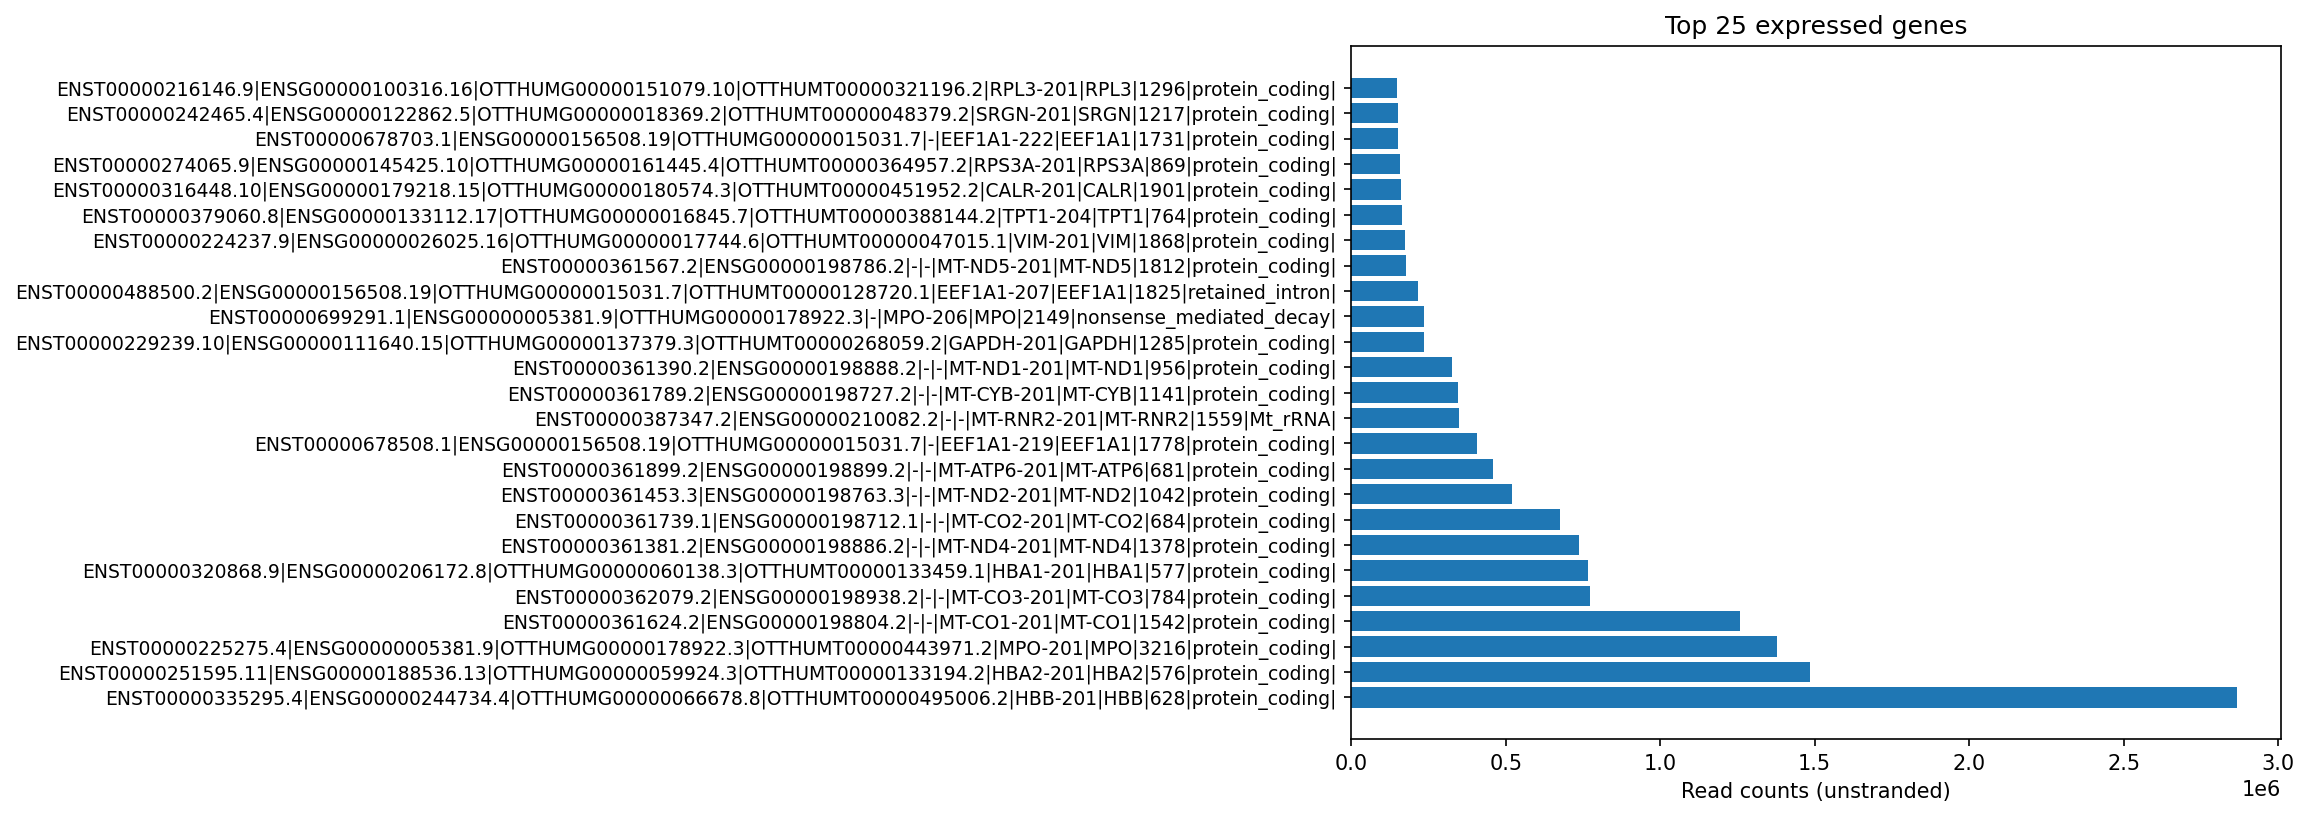

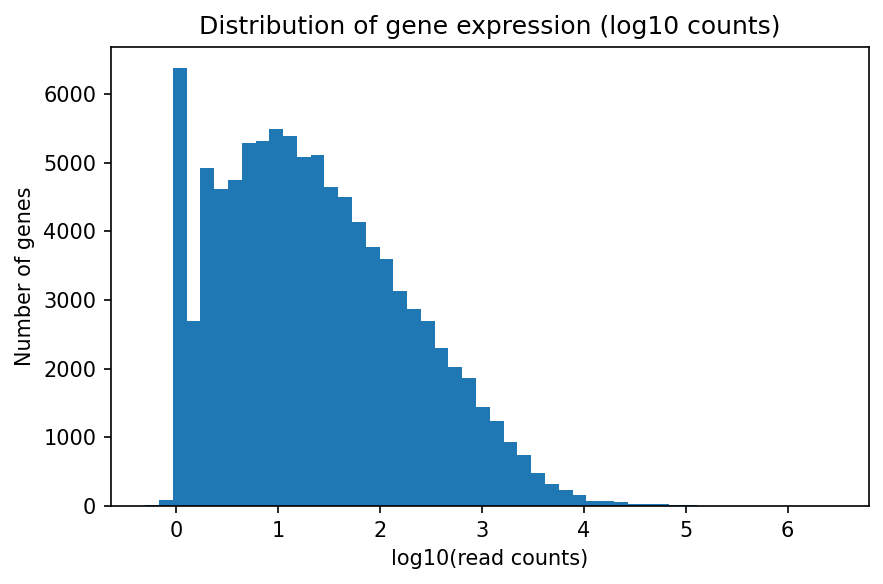

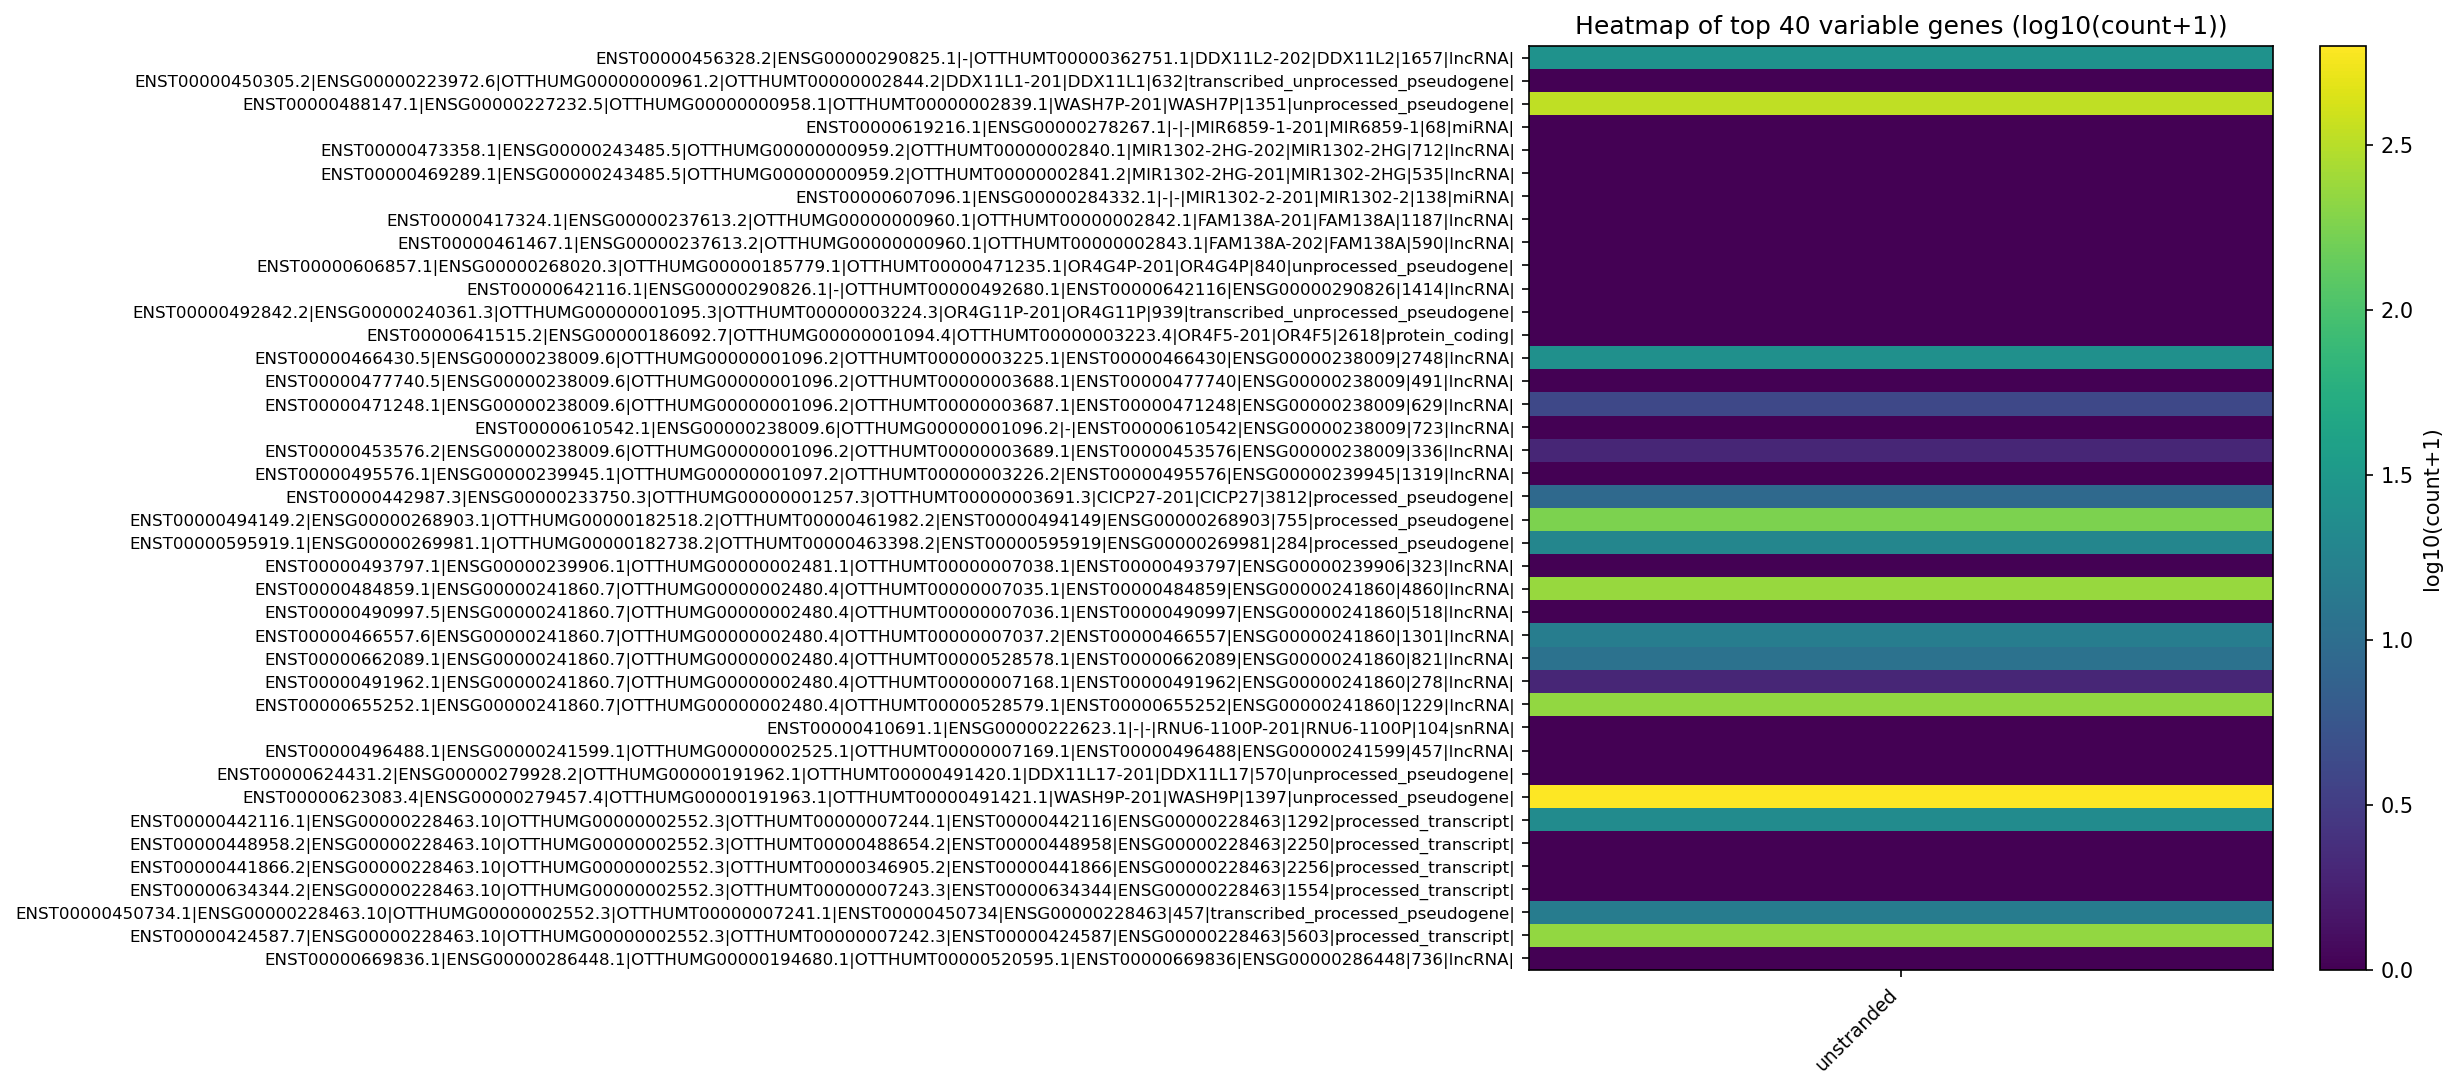

In [17]:
from pathlib import Path
from IPython.display import display, Image, HTML

out = Path("/mnt/a/Projects/RA_Assignment/rnaseq_results/Patient1")

# look for expected PNGs
plots = {
    "Top genes": out / "top_genes.png",
    "Counts distribution": out / "counts_dist.png",
    "Top-variable genes heatmap": out / "heatmap_top_var_genes.png",
}

found = False
for name, p in plots.items():
    if p.exists():
        found = True
        display(HTML(f"<h3>{name}</h3>"))
        display(Image(str(p)))
if not found:
    display(HTML("<b>No pipeline plots found at expected locations.</b>"))
    # show any pngs in folder
    pngs = list(out.rglob("*.png"))
    if pngs:
        display(HTML("<p>Other PNG files found:</p>"))
        for p in pngs:
            display(HTML(f"<b>{p.relative_to(out)}</b>"))
            display(Image(str(p)))
    else:
        display(HTML("<p>No PNG files found under the output directory.</p>"))
